Mixup 실습

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

모델정의

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(16 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    

데이터 정의

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.3,0.3,0.3))
])

train_dataset = datasets.CIFAR10(root='../99_StudyFiles/02_Data/', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


데이터 정의

In [4]:
model = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [5]:
def mixup_data(x,y, alpha=1.0):
    batch_size = x.size(0)      # 입력 데이터 x 배치 사이즈
    lam = torch.rand(batch_size, 1,1,1)    # 0 ~ 1 사이 랜덤 값을 갖는 lambda -> mixup의 비율
    lam = torch.max(lam, 1 - lam)   # 최소값 0.5 이상 유지 lam에서 1 - lam 사이의 최대값 선택
    mixed_x = lam * x + (1 - lam) * x.flip(dims=[0,2,3])
    # lam * x : x에 lam 곱하기
    # x.flip : 배치 차원으로 기준으로 뒤집고 (1-lam) 비율로 곱셈
    
    indices = torch.randperm(batch_size) # batch_size 범위에서 랜덤한 정수 생성
    mixed_y = lam.squeeze() * y + (1 - lam.squeeze()) * y[indices]
    # lam.squeeze() * y -> y 라벨에 lam 비율 값 곱해준다
    # (1 - lam.squeeze()) * y[indices] -> 랜덤한 라벨 y에 1 - lam.squeeze()(비율) 곱하기
    
    mixed_y = mixed_y.type(torch.long)  # 타입변환
    
    return mixed_x, mixed_y

In [6]:
def plot_images(images, labels, title):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)
    labels = labels.numpy ()
    for i, ax in enumerate (axes.flat):
        image = images[i].squeeze()
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

학습 Loop 만들기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

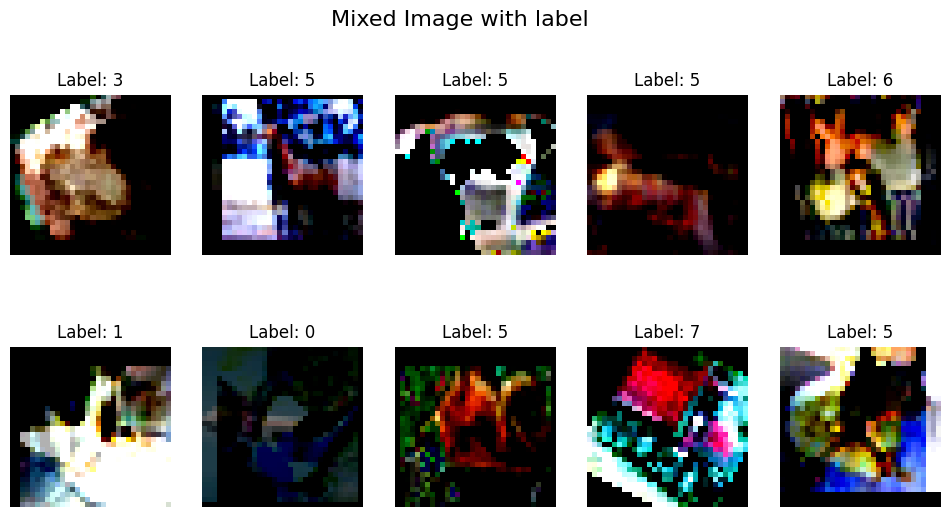

TypeError: 'float' object is not iterable

In [10]:
num_epochs = 10

train_losses_no_mixup = []
train_losses_with_mixup = []

end_idx = 0
for epoch in range(num_epochs):
    train_loss_no = 0.0
    train_loss = 0.0
    
    for inputs, labels in train_loader :
        optimizer.zero_grad()
        
        images_temp, labels_temp = inputs, labels   # origin data
        
        inputs, labels = mixup_data(inputs, labels) # mixup data
        
        # mixed images with label smoothing
        mixed_x, mixed_y = mixup_data(inputs, labels)
        
        mixed_images = mixed_x.cpu().numpy()
        mixed_images = np.transpose(mixed_images, (0,2,3,1))
        mixed_images = np.squeeze(mixed_images)
        
        if end_idx == 0 :
            plot_images(mixed_images, mixed_y.squeeze(), 'Mixed Image with label')
            end_idx = 1
            
        outputs_no_mixup = model(images_temp)
        outputs_mixup = model(inputs)
        
        labels = torch.squeeze(labels) # conver labels to 1D tensor
        
        loss_no_mixup = criterion(outputs_no_mixup, labels)
        loss_mixup = criterion(outputs_mixup, labels)
        
        loss_no_mixup.backward()
        loss_mixup.backward()
        optimizer.step()
        
        train_losses_no_mixup += loss_no_mixup.item()
        train_losses_with_mixup += loss_mixup.item()
        
        # 에포크 마다 손실 기록
        train_losses_no_mixup.append(train_loss_no / len(train_loader))
        train_losses_with_mixup.append(train_loss / len(train_loader))

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

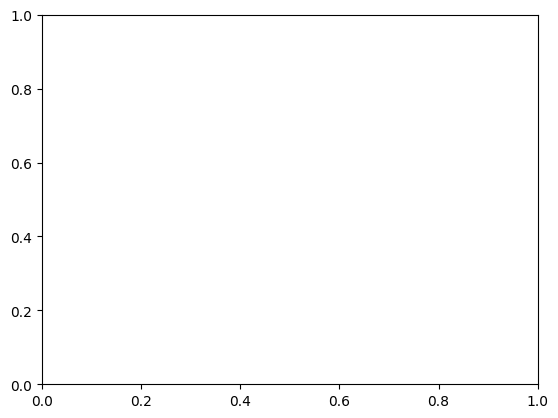

In [ ]:
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_losses_no_mixup, labels='No MixedUp')
plt.plot(epochs, train_losses_with_mixup, labels='MixedUp')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()